# A Google Meridian PyMC-Marketing Comparison

## The Data

This dataset is **synthetically generated** and designed for **simple demonstration purposes**.  
It is **not reflective of real-world marketing mix modeling (MMM) scenarios**, where data complexity, noise, and non-linear effects are much greater.  
Instead, this data is intended to illustrate the basic structure and workflow of an MMM analysis in a controlled, simplified setting.

You can find the dataset [here](https://www.pymc-marketing.io/en/stable/notebooks/mmm/mmm_example.html#generate-data).

In [2]:
import pandas as pd

data_url = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/data/mmm_example.csv"
data = pd.read_csv(data_url, parse_dates=["date_week"])
data.head()

,date_week,y,x1,x2,event_1,event_2,dayofyear,t
0,2018-04-02,3984.662237,0.318580,0.0,0.0,0.0,92,0
1,2018-04-09,3762.871794,0.112388,0.0,0.0,0.0,99,1
2,2018-04-16,4466.967388,0.292400,0.0,0.0,0.0,106,2
3,2018-04-23,3864.219373,0.071399,0.0,0.0,0.0,113,3
4,2018-04-30,4441.625278,0.386745,0.0,0.0,0.0,120,4


## PyMC-Marketing MMM

In [40]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from pymc_marketing.mmm import (
    GeometricAdstock,
    LogisticSaturation,
    MMM,
)

### Model Specification

This is a national model with the following specification:

$$
y_{t} = \mu + \sum_{i=0}^{4} \gamma^{[F]}_{i} f_{t,i} 
+ \sum_{i=1}^{N_C} \gamma^{[C]}_{i} z_{t,i} 
+ \sum_{i=1}^{N_M} \beta^{[M]}_{i} \text{LogisticAdstock} \left( \{ x^{[M]}_{t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, \lambda^{[M]}_i \right) + \epsilon_{t}
$$

Where:

- $\mu$ represents the intercept.
- $\sum_{i=0}^{4} \gamma^{[F]}_{i} f_{t,i}$ represents the seasonality/fourier contribution (order 2).
- $\sum_{i=1}^{N_C} \gamma^{[C]}_{i} z_{t,i}$ represents the control contribution.
- $\sum_{i=1}^{N_M} \beta^{[M]}_{i} \text{LogisticAdstock} \left( \{ x^{[M]}_{t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, \lambda^{[M]}_i \right)$ represents the adstocked saturated media contribution.

**Note** This default configuration has been used:

- $\mu \sim $ Normal(0,2)
- $\beta^{[M]}_i \sim $ HalfNormal(2)
- $\gamma^{[C]} \sim $ Normal(0,2)
- $\gamma^{[F]} \sim $ Laplace(0,1)
- $\alpha^{[M]} \sim $ Beta(1,3)
- $\lambda^{[M]} \sim $ Gamma(3,1)
- $\sigma \sim $ HalfNormal(2) 

In [14]:
# Compile the model.
mmm = MMM(
    date_column="date_week",
    channel_columns=["x1", "x2"],
    adstock=GeometricAdstock(l_max=12),
    saturation=LogisticSaturation(),
    control_columns=['event_1', 'event_2', 't'],
    yearly_seasonality=2,
)
# Generate prior predictive samples
mmm.sample_prior_predictive(X, y, samples=2_000)
# View the model configuration.
mmm.model_config

{'intercept': Prior("Normal", mu=0, sigma=2),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
 'gamma_control': Prior("Normal", mu=0, sigma=2, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
 'adstock_alpha': Prior("Beta", alpha=1, beta=3, dims="channel"),
 'saturation_lam': Prior("Gamma", alpha=3, beta=1, dims="channel"),
 'saturation_beta': Prior("HalfNormal", sigma=2, dims="channel")}

In [26]:
# Separate the dependent and independent variables
X = data.drop("y", axis=1)
y = data["y"]
# Fit the model
mmm.fit(X=X, y=y, chains=4, target_accept=0.85)
# Generate posterior predictive samples
mmm.sample_posterior_predictive(X, extend_idata=True, combined=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, adstock_alpha, saturation_lam, saturation_beta, gamma_control, gamma_fourier, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
Sampling: [y]


Output()

<xarray.Dataset> Size: 6MB
Dimensions:  (sample: 4000, date: 179)
Coordinates:
  * date     (date) datetime64[ns] 1kB 2018-04-02 2018-04-09 ... 2021-08-30
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 6MB 3.805e+03 4.34e+03 ... 4.662e+03
Attributes:
    created_at:                 2025-04-28T13:02:47.252733+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.22.0

### Model Diagnostics

In [27]:
# Assess parameter estimates + HDI's + convergences via r_hats.
az.summary(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "y_sigma",
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
        "gamma_control",
        "gamma_fourier",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.349,0.013,0.326,0.374,0.000,0.000,1903.0,2412.0,1.0
y_sigma,0.030,0.002,0.027,0.033,0.000,0.000,3860.0,2985.0,1.0
saturation_beta[x1],0.362,0.019,0.329,0.399,0.000,0.000,1931.0,2172.0,1.0
saturation_beta[x2],0.265,0.063,0.192,0.369,0.002,0.001,1232.0,1271.0,1.0
saturation_lam[x1],4.068,0.365,3.375,4.750,0.007,0.005,2375.0,2025.0,1.0
saturation_lam[x2],3.188,1.166,1.204,5.333,0.032,0.023,1235.0,1242.0,1.0
adstock_alpha[x1],0.398,0.029,0.342,0.451,0.001,0.000,2362.0,2811.0,1.0
adstock_alpha[x2],0.191,0.041,0.112,0.262,0.001,0.001,1676.0,1818.0,1.0
gamma_control[event_1],0.246,0.031,0.186,0.301,0.000,0.000,4917.0,3014.0,1.0
gamma_control[event_2],0.327,0.031,0.271,0.388,0.000,0.000,4061.0,2859.0,1.0


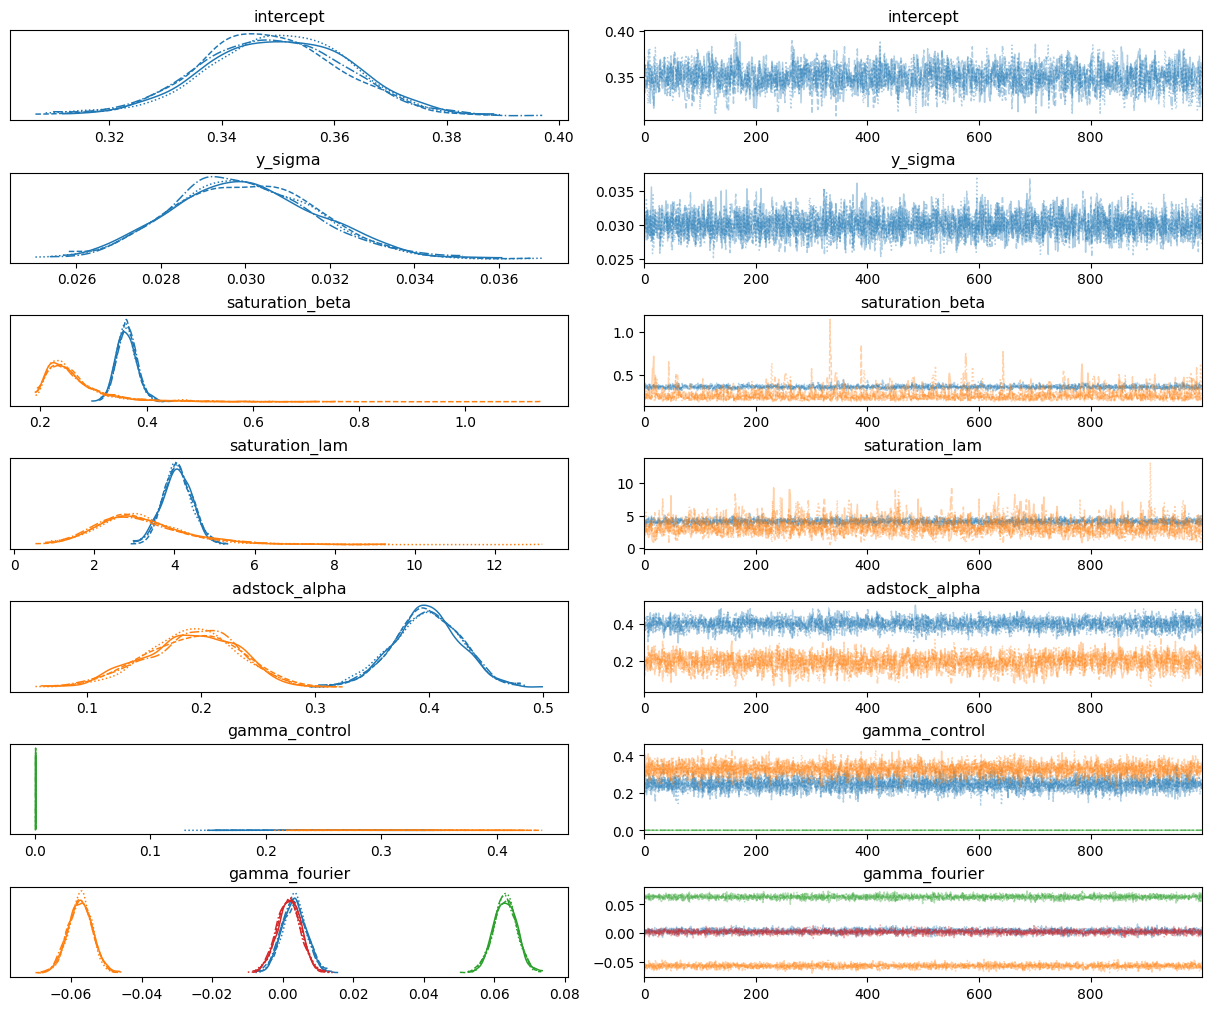

In [28]:
# Diagnostic Visuals
_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=[
        "intercept",
        "y_sigma",
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
        "gamma_control",
        "gamma_fourier",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)

### Output Visuals
- Model fit
- Channel Contributions
- Response curves

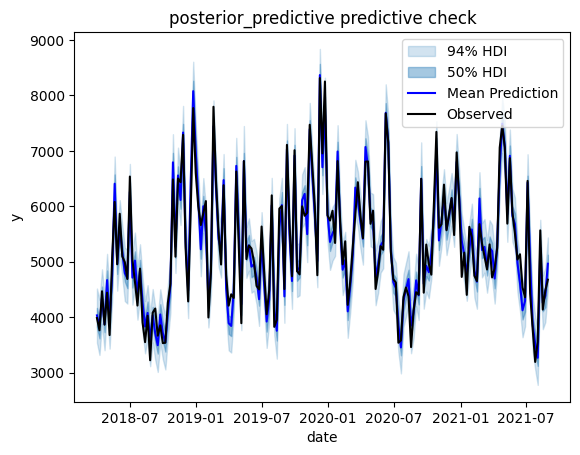

In [43]:
mmm.plot_posterior_predictive(original_scale=True);

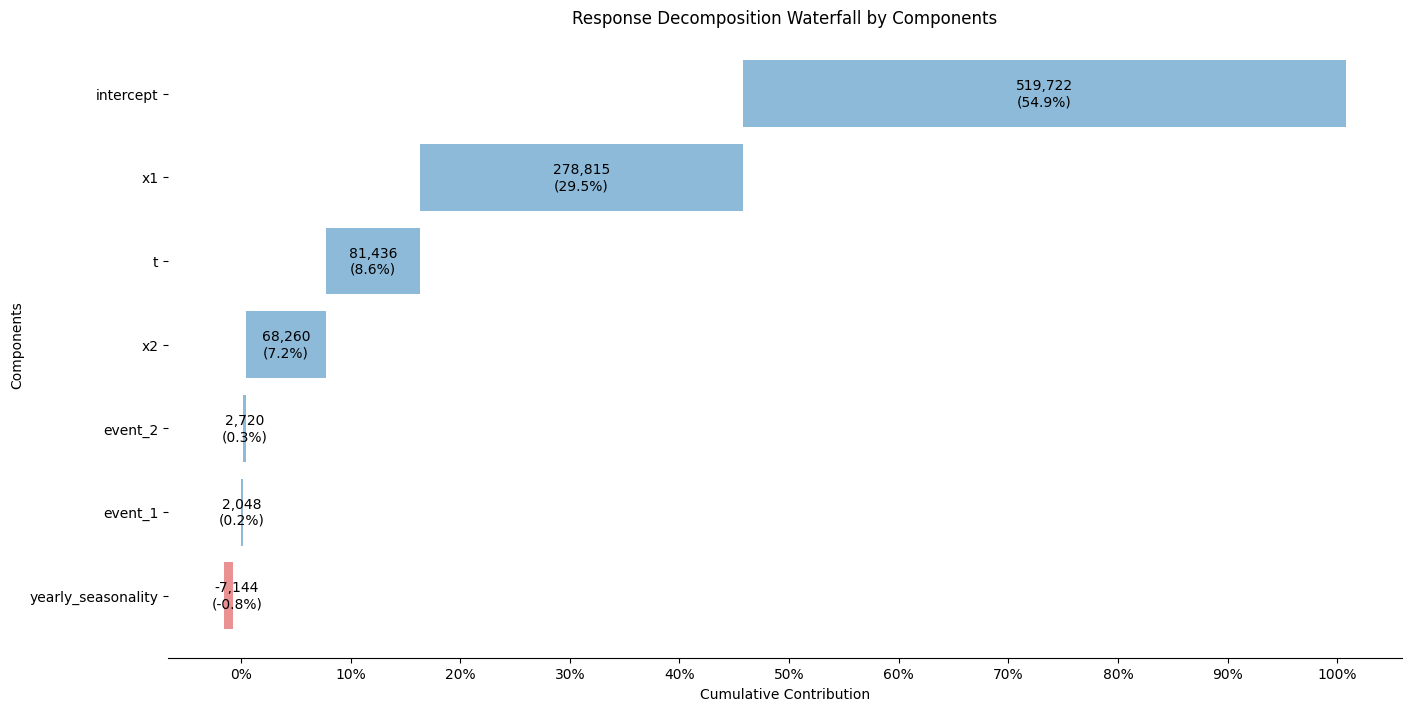

In [44]:
mmm.plot_waterfall_components_decomposition();

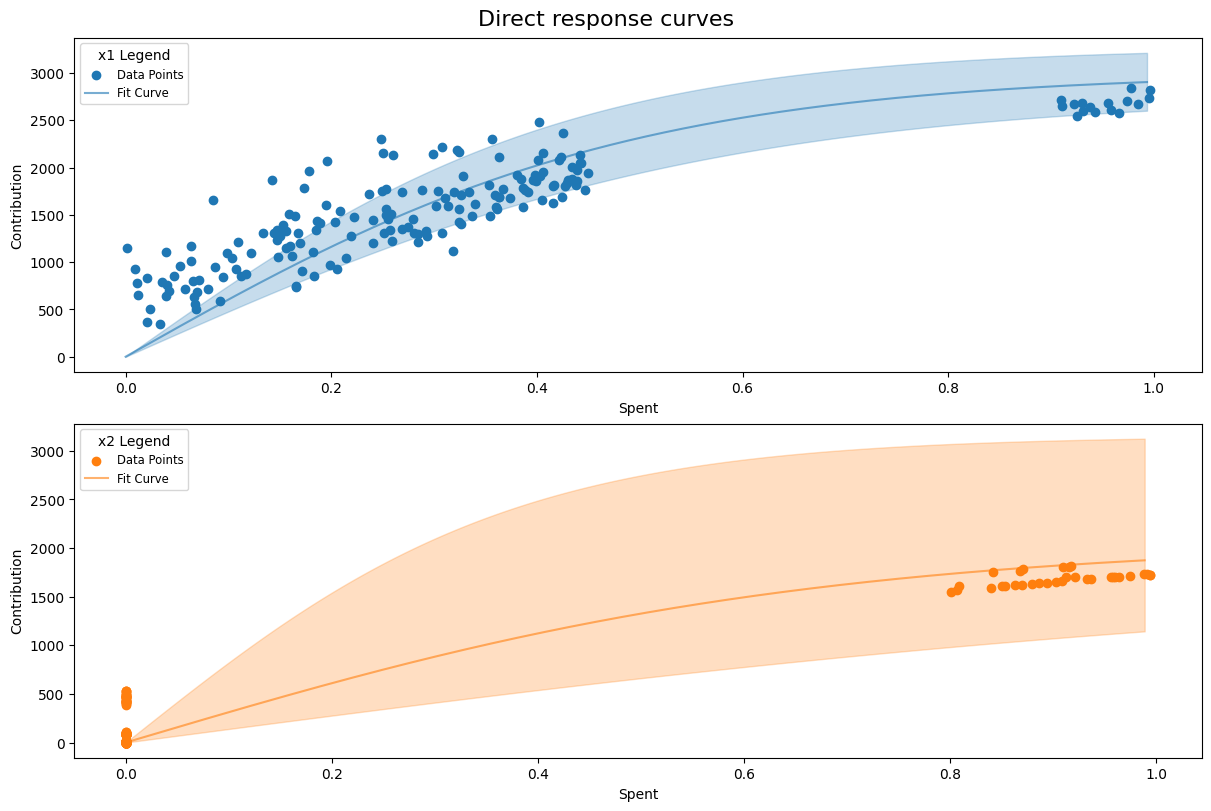

In [36]:
fig = mmm.plot_direct_contribution_curves(show_fit = True);

## Meridian MMM

In [45]:
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns

import IPython

from meridian import constants
from meridian.data import load
from meridian.data import test_utils
from meridian.model import model
from meridian.model import spec
from meridian.model import prior_distribution
from meridian.analysis import optimizer
from meridian.analysis import analyzer
from meridian.analysis import visualizer
from meridian.analysis import summarizer
from meridian.analysis import formatter

### Model Specification

As this is a national model:

- $\eta = 0$ for all channels. This parameter represents the global mean for the beta prior variance across all geo's.
- $\xi = 0$ for all controls. This parameter represents the global variance prior for gamma variance across all geo's
- $\beta^{[M]}_{g,i} = \beta^{[M]}_{i}$ for all channels $i$
- $\gamma^{[C]}_{g,i} = \gamma^{[C]}_{i}$ for all controls $i$
- $\tau_g = 0$

So the model becomes:

$$
y_{g,t} = \mu_t 
+ \sum_{i=1}^{N_C} \gamma^{[C]}_{i} z_{t,i} 
+ \sum_{i=1}^{N_M} \beta^{[M]}_{i} \text{HillAdstock} \left( \{ x^{[M]}_{t-s,i} \}_{s=0}^{L} ; \alpha^{[M]}_i, ec^{[M]}_i, slope^{[M]}_i \right) + \epsilon_{t}
$$


The default configuration has been used. That is:

- $\beta^{[M]}_i \sim $ LogNormal(5)
- $\gamma^{[C]} \sim $ Normal(0,5)
- $\alpha^{[M]} \sim $ Uniform(0,1)
- $ec^{[M]} \sim $ TruncatedNormal(l = 0.1, u = 10, $\mu$ = 0.8, $\sigma$ = 0.8)
- $slope^{[M]} \sim $ Determinstic(1), meaning slope = 1
- $\sigma \sim $ HalfNormal(5) 

In [46]:
# Map column names to variable types
coord_to_columns = load.CoordToColumns(
    time='date_week',
    controls=['event_1', 'event_2', 't'],
    kpi='y',
    media=['x1', 'x2'],
    media_spend=['x1', 'x2'],
)

correct_media_to_channel = {'x1': 'x1', 'x2': 'x2'}

In [47]:
# Load the data and assing coordinates
loader = load.CsvDataLoader(
    csv_path=f'https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/data/mmm_example.csv',
    kpi_type='revenue',
    coord_to_columns=coord_to_columns,
    media_to_channel=correct_media_to_channel,
    media_spend_to_channel=correct_media_to_channel,
)
data = loader.load()

/opt/anaconda3/envs/meridian_env/lib/python3.12/site-packages/meridian/data/load.py:1020: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df[geo_column_name] = self.df[geo_column_name].replace(
/opt/anaconda3/envs/meridian_env/lib/python3.12/site-packages/meridian/data/load.py:201: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if (constants.GEO) not in self.dataset.dims.keys():
/opt/anaconda3/envs/meridian_env/lib/python3.12/site-packages/meridian/data/load.py:206: UserWarning: The `population` argument is ignored in a nationally aggregated model. It will b

In [51]:
# Specify and compile the model.
model_spec = spec.ModelSpec(
    prior=prior_distribution.PriorDistribution(),
    media_effects_dist='log_normal',
    hill_before_adstock=False,
    max_lag=12,
    unique_sigma_for_each_geo=False,
    paid_media_prior_type='coefficient',
    roi_calibration_period=None,
    rf_roi_calibration_period=None,
    knots=None,
    baseline_geo=None,
    holdout_id=None,
    control_population_scaling_id=None,
)
meridian = model.Meridian(input_data=data, model_spec=model_spec)
# Sample the prior.
meridian.sample_prior(1000)

/opt/anaconda3/envs/meridian_env/lib/python3.12/site-packages/meridian/model/prior_distribution.py:846: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. tau_g_excl_baseline has been automatically set to Deterministic(0).
  warnings.warn(
/opt/anaconda3/envs/meridian_env/lib/python3.12/site-packages/meridian/model/prior_distribution.py:846: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_m has been automatically set to Deterministic(0).
  warnings.warn(
/opt/anaconda3/envs/meridian_env/lib/python3.12/site-packages/meridian/model/prior_distribution.py:846: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_rf has been automatically set to Deterministic(0).
  warnings.warn(
/opt/anaconda3/envs/meridian_env/lib/python3.12/site-packages/meridian/model/prior_distribution.py:846: UserWarning: Hierarchical distribution parameters 

In [52]:
# Fit the model
meridian.sample_posterior(n_chains=4, n_adapt=1000, n_burnin=500, n_keep=1000)

2025-04-28 14:28:01.469877: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1745846881.739706  871898 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed
W0000 00:00:1745846881.947142  871898 assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert
/opt/anaconda3/envs/meridian_env/lib/python3.12/site-packages/arviz/data/inference_data.py:157: UserWarning: trace group is not defined in the InferenceData scheme
  warnings.warn(
/opt/anaconda3/envs/meridian_env/lib/python3.12/site-packages/arviz/data/inference_data.py:1655: UserWarning: trace group is not defined in the InferenceData scheme
  warnings.warn(


### Model Diagnostics

In [53]:
true_count = meridian.inference_data.trace.diverging.sum()
print(f"Number of Divergences: {true_count.values}")

Number of Divergences: 0


In [54]:
max_rhat = az.summary(meridian.inference_data)['r_hat'].max()
print(f"Max rhat: {max_rhat}")

/opt/anaconda3/envs/meridian_env/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


Max rhat: 1.0


/opt/anaconda3/envs/meridian_env/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
